In [20]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# load data
df = pd.read_excel('/content/drive/MyDrive/OnlineRetail.xlsx')

print("Shape:", df.shape)
df.head()


Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


In [22]:
df.isnull().sum()


,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [23]:
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
UnitPrice,float64
CustomerID,float64
Country,object


In [24]:
# keep a copy of raw data
df_raw = df.copy()

# filter rows with valid CustomerID
df_cust = df[df['CustomerID'].notna()].copy()

print("Original rows:", df_raw.shape[0])
print("Rows with CustomerID:", df_cust.shape[0])
print("Rows removed:", df_raw.shape[0] - df_cust.shape[0])


Original rows: 541909
Rows with CustomerID: 406829
Rows removed: 135080


In [25]:
# cancellations by invoice number
cancelled_invoices = df_cust['InvoiceNo'].astype(str).str.startswith('C').sum()

# returned items by quantity
returned_rows = (df_cust['Quantity'] < 0).sum()

print("Cancelled invoice rows:", cancelled_invoices)
print("Returned (negative quantity) rows:", returned_rows)


Cancelled invoice rows: 8905
Returned (negative quantity) rows: 8905


In [26]:
df_purchases = df_cust[
    (~df_cust['InvoiceNo'].astype(str).str.startswith('C')) &
    (df_cust['Quantity'] > 0) &
    (df_cust['UnitPrice'] > 0)
].copy()

print("Customer rows before cleaning:", df_cust.shape[0])
print("Customer rows after cleaning:", df_purchases.shape[0])
print("Rows removed:", df_cust.shape[0] - df_purchases.shape[0])


Customer rows before cleaning: 406829
Customer rows after cleaning: 397884
Rows removed: 8945


In [27]:
print("Any negative quantities left?", (df_purchases['Quantity'] <= 0).any())
print("Any zero/negative prices left?", (df_purchases['UnitPrice'] <= 0).any())


Any negative quantities left? False
Any zero/negative prices left? False


In [28]:
df_purchases['TotalPrice'] = (
    df_purchases['Quantity'] * df_purchases['UnitPrice']
)
print(df_purchases[['Quantity', 'UnitPrice', 'TotalPrice']].head()
)

   Quantity  UnitPrice  TotalPrice
0         6       2.55       15.30
1         6       3.39       20.34
2         8       2.75       22.00
3         6       3.39       20.34
4         6       3.39       20.34


In [29]:
df_purchases[['Quantity', 'UnitPrice', 'TotalPrice']].describe()


,Quantity,UnitPrice,TotalPrice
count,397884.00,397884.00,397884.00
mean,12.99,3.12,22.40
std,179.33,22.10,309.07
min,1.00,0.00,0.00
25%,2.00,1.25,4.68
50%,6.00,1.95,11.80
75%,12.00,3.75,19.80
max,80995.00,8142.75,168469.60


In [30]:
customer_stats = df_purchases.groupby('CustomerID').agg(
    num_invoices=('InvoiceNo', 'nunique'),
    total_quantity=('Quantity', 'sum'),
    total_spent=('TotalPrice', 'sum')
)

customer_stats.describe()


,num_invoices,total_quantity,total_spent
count,4338.00,4338.00,4338.00
mean,4.27,1191.29,2054.27
std,7.70,5046.08,8989.23
min,1.00,1.00,3.75
25%,1.00,160.00,307.41
50%,2.00,379.00,674.49
75%,5.00,992.75,1661.74
max,209.00,196915.00,280206.02


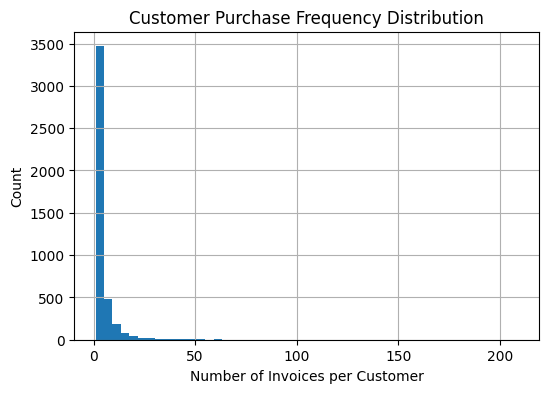

In [31]:
plt.figure(figsize=(6,4))
customer_stats['num_invoices'].hist(bins=50)
plt.xlabel('Number of Invoices per Customer')
plt.ylabel('Count')
plt.title('Customer Purchase Frequency Distribution')
plt.show()


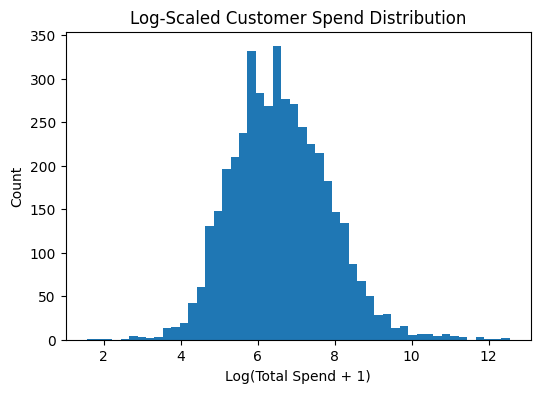

In [32]:
plt.figure(figsize=(6,4))
plt.hist(np.log1p(customer_stats['total_spent']), bins=50)
plt.xlabel('Log(Total Spend + 1)')
plt.ylabel('Count')
plt.title('Log-Scaled Customer Spend Distribution')
plt.show()


In [33]:
reference_date = df_purchases['InvoiceDate'].max()
reference_date


Timestamp('2011-12-09 12:50:00')

In [34]:
rfm = df_purchases.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalPrice', 'sum')
)

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.00,325,1,77183.60
12347.00,1,7,4310.00
12348.00,74,4,1797.24
12349.00,18,1,1757.55
12350.00,309,1,334.40


In [35]:
rfm.describe()


,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00
mean,91.54,4.27,2054.27
std,100.01,7.70,8989.23
min,0.00,1.00,3.75
25%,17.00,1.00,307.41
50%,50.00,2.00,674.49
75%,141.00,5.00,1661.74
max,373.00,209.00,280206.02


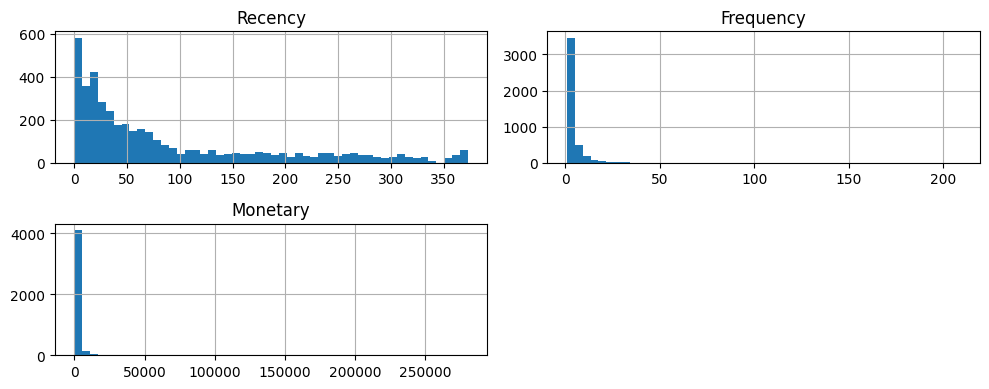

In [37]:
rfm.hist(figsize=(10,4), bins=50)
plt.tight_layout()
plt.show()


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

rfm_scaled_df = pd.DataFrame(
    rfm_scaled,
    index=rfm.index,
    columns=rfm.columns
)

rfm_scaled_df.describe()


,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00
mean,0.00,0.00,0.00
std,1.00,1.00,1.00
min,-0.92,-0.43,-0.23
25%,-0.75,-0.43,-0.19
50%,-0.42,-0.30,-0.15
75%,0.49,0.09,-0.04
max,2.81,26.60,30.95


In [39]:
from sklearn.cluster import KMeans

wcss = []

K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)


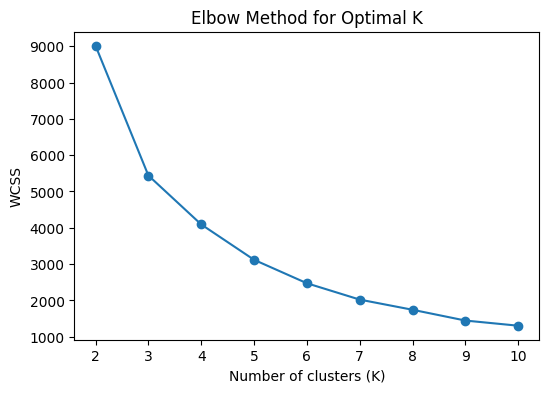

In [40]:
plt.figure(figsize=(6,4))
plt.plot(K_range, wcss, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()


In [41]:
kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

rfm['RFM_Cluster'] = kmeans.fit_predict(rfm_scaled_df)


In [42]:
rfm['RFM_Cluster'].value_counts().sort_index()


,count
RFM_Cluster,
0,1082
1,3230
2,26


In [43]:
rfm_cluster_summary = rfm.groupby('RFM_Cluster').agg(
    Recency_mean=('Recency', 'mean'),
    Frequency_mean=('Frequency', 'mean'),
    Monetary_mean=('Monetary', 'mean'),
    Count=('Recency', 'count')
)

rfm_cluster_summary


,Recency_mean,Frequency_mean,Monetary_mean,Count
RFM_Cluster,,,,
0,246.11,1.58,631.42,1082
1,40.45,4.67,1855.94,3230
2,5.04,66.42,85904.35,26


In [44]:
rfm_cluster_median = rfm.groupby('RFM_Cluster').agg(
    Recency_median=('Recency', 'median'),
    Frequency_median=('Frequency', 'median'),
    Monetary_median=('Monetary', 'median')
)

rfm_cluster_median


,Recency_median,Frequency_median,Monetary_median
RFM_Cluster,,,
0,241.00,1.00,310.74
1,29.00,3.00,917.77
2,2.50,53.00,59796.87


In [46]:
rfm_label_map = {
    0: 'Low',
    1: 'Mid',
    2: 'High'
}

rfm['RFM_Segment'] = rfm['RFM_Cluster'].map(rfm_label_map)

rfm[['RFM_Cluster', 'RFM_Segment']].head()


,RFM_Cluster,RFM_Segment
CustomerID,,
12346.00,0,Low
12347.00,1,Mid
12348.00,1,Mid
12349.00,1,Mid
12350.00,0,Low


In [47]:
invoice_level = df_purchases.groupby(
    ['CustomerID', 'InvoiceNo', 'InvoiceDate']
).agg(
    invoice_quantity=('Quantity', 'sum')
).reset_index()

invoice_level.head()


,CustomerID,InvoiceNo,InvoiceDate,invoice_quantity
0,12346.00,541431,2011-01-18 10:01:00,74215
1,12347.00,537626,2010-12-07 14:57:00,319
2,12347.00,542237,2011-01-26 14:30:00,315
3,12347.00,549222,2011-04-07 10:43:00,483
4,12347.00,556201,2011-06-09 13:01:00,196


In [48]:
behavior = invoice_level.groupby('CustomerID').agg(
    avg_qty=('invoice_quantity', 'mean'),
    std_qty=('invoice_quantity', 'std'),
    max_qty=('invoice_quantity', 'max'),
    avg_gap_days=('InvoiceDate', lambda x: x.sort_values().diff().dt.days.mean())
)


In [49]:
behavior.isnull().sum()


,0
avg_qty,0
std_qty,1491
max_qty,0
avg_gap_days,1491


In [50]:
behavior['std_qty'] = behavior['std_qty'].fillna(0)
behavior['avg_gap_days'] = behavior['avg_gap_days'].fillna(behavior['avg_gap_days'].max())


In [51]:
behavior.describe()


,avg_qty,std_qty,max_qty,avg_gap_days
count,4338.00,4338.00,4338.00,4338.00
mean,253.12,106.51,404.32,172.71
std,1312.72,893.62,1793.60,148.92
min,1.00,0.00,1.00,0.00
25%,93.00,0.00,121.00,40.44
50%,161.42,40.53,224.00,94.00
75%,271.98,113.86,408.00,365.00
max,74215.00,57270.70,80995.00,365.00


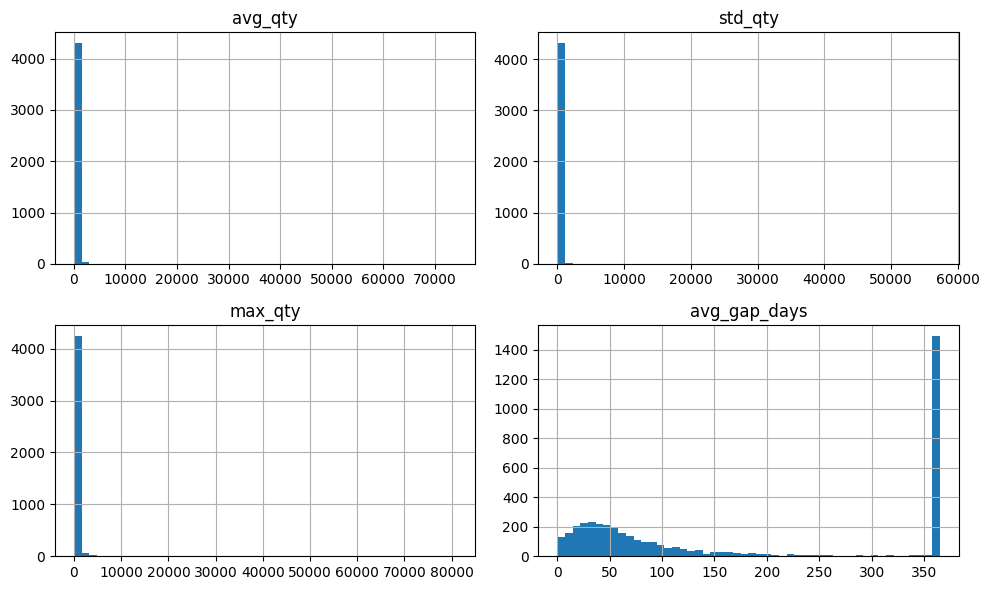

In [52]:
behavior.hist(figsize=(10,6), bins=50)
plt.tight_layout()
plt.show()


In [53]:
from sklearn.preprocessing import StandardScaler

behavior_scaler = StandardScaler()
behavior_scaled = behavior_scaler.fit_transform(behavior)

behavior_scaled_df = pd.DataFrame(
    behavior_scaled,
    index=behavior.index,
    columns=behavior.columns
)

behavior_scaled_df.describe()


,avg_qty,std_qty,max_qty,avg_gap_days
count,4338.00,4338.00,4338.00,4338.00
mean,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-0.19,-0.12,-0.22,-1.16
25%,-0.12,-0.12,-0.16,-0.89
50%,-0.07,-0.07,-0.10,-0.53
75%,0.01,0.01,0.00,1.29
max,56.35,63.98,44.94,1.29


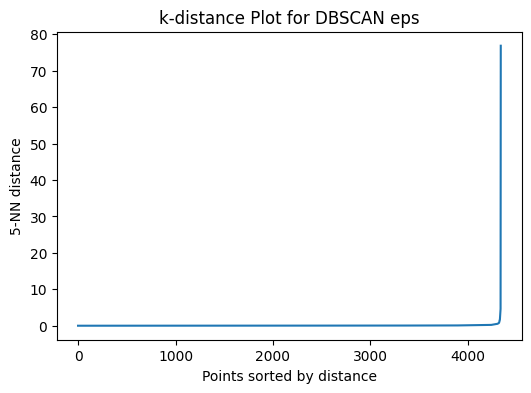

In [54]:
from sklearn.neighbors import NearestNeighbors

k = 5  # common starting point
nbrs = NearestNeighbors(n_neighbors=k)
nbrs.fit(behavior_scaled_df)

distances, _ = nbrs.kneighbors(behavior_scaled_df)
k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-NN distance')
plt.title('k-distance Plot for DBSCAN eps')
plt.show()


In [55]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
    eps=0.5,
    min_samples=5
)

behavior['Behavior_Cluster'] = dbscan.fit_predict(behavior_scaled_df)


In [56]:
behavior['Behavior_Cluster'].value_counts()


,count
Behavior_Cluster,
0,4295
-1,24
2,7
1,4
3,4
4,4


In [57]:
behavior.groupby('Behavior_Cluster').agg(
    avg_qty_mean=('avg_qty', 'mean'),
    max_qty_mean=('max_qty', 'mean'),
    avg_gap_mean=('avg_gap_days', 'mean'),
    count=('avg_qty', 'count')
)


,avg_qty_mean,max_qty_mean,avg_gap_mean,count
Behavior_Cluster,,,,
-1,7114.77,12635.62,100.39,24
0,209.29,318.56,173.45,4295
1,2797.25,2797.25,365.00,4
2,784.71,4748.43,12.17,7
3,1800.46,3460.00,65.38,4
4,1121.60,6058.00,11.98,4


In [58]:
def map_behavior(cluster_id):
    if cluster_id == 0:
        return 'Regular'
    elif cluster_id == -1:
        return 'Anomaly'
    else:
        return 'Bulk'

behavior['Behavior_Segment'] = behavior['Behavior_Cluster'].apply(map_behavior)

behavior['Behavior_Segment'].value_counts()


,count
Behavior_Segment,
Regular,4295
Anomaly,24
Bulk,19


In [59]:
behavior.groupby('Behavior_Segment').agg(
    avg_qty_mean=('avg_qty', 'mean'),
    max_qty_mean=('max_qty', 'mean'),
    avg_gap_mean=('avg_gap_days', 'mean'),
    count=('avg_qty', 'count')
)


,avg_qty_mean,max_qty_mean,avg_gap_mean,count
Behavior_Segment,,,,
Anomaly,7114.77,12635.62,100.39,24
Bulk,1493.17,4342.11,97.61,19
Regular,209.29,318.56,173.45,4295


In [60]:
customer_segments = (
    rfm[['RFM_Segment']]
    .join(behavior[['Behavior_Segment']], how='left')
)

customer_segments.head()


,RFM_Segment,Behavior_Segment
CustomerID,,
12346.00,Low,Anomaly
12347.00,Mid,Regular
12348.00,Mid,Regular
12349.00,Mid,Regular
12350.00,Low,Regular


In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
behavior_pca = pca.fit_transform(behavior_scaled_df)

behavior_pca_df = pd.DataFrame(
    behavior_pca,
    columns=['PC1', 'PC2'],
    index=behavior.index
)

behavior_pca_df['Behavior_Cluster'] = behavior['Behavior_Cluster']
behavior_pca_df['Behavior_Segment'] = behavior['Behavior_Segment']


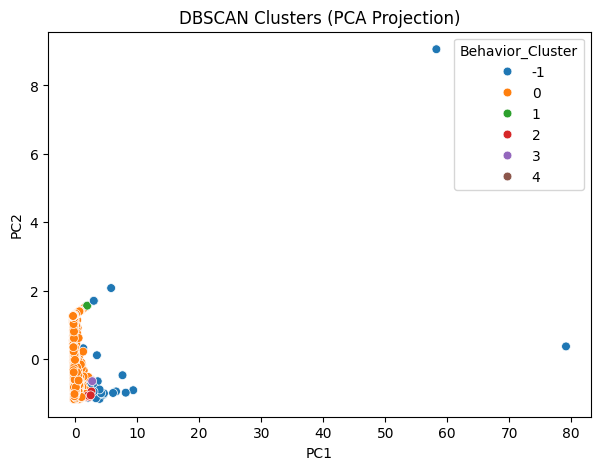

In [62]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=behavior_pca_df,
    x='PC1',
    y='PC2',
    hue='Behavior_Cluster',
    palette='tab10',
    s=40
)
plt.title('DBSCAN Clusters (PCA Projection)')
plt.show()


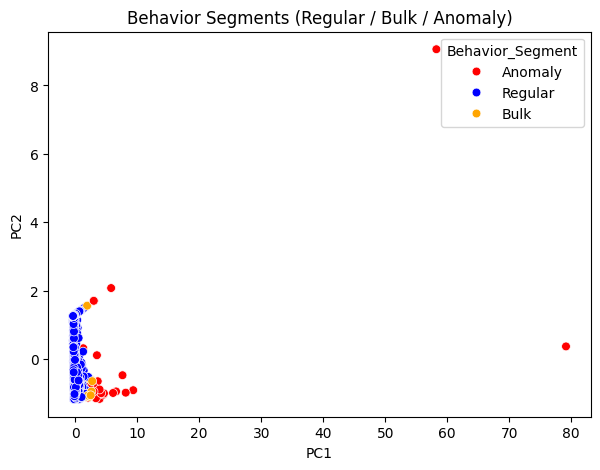

In [63]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=behavior_pca_df,
    x='PC1',
    y='PC2',
    hue='Behavior_Segment',
    palette={'Regular': 'blue', 'Bulk': 'orange', 'Anomaly': 'red'},
    s=40
)
plt.title('Behavior Segments (Regular / Bulk / Anomaly)')
plt.show()
